# One Notebook To Rule Them All

In this notebook we combine what we know about Infrastructure as Code for building an AWS architecture and cleaning reasonably sized data with Pandas in a notebook.

What is implemented here with explanation has been transferred to the Python files for running the project.

The below image is a reminder of the data model we are going to implementing.

![ERD](erd.png)

In [1]:
import pandas as pd
import seaborn as sns
import psycopg2
import boto3
import configparser

import logging
import boto3
from botocore.exceptions import ClientError

## 1. Set up Boto3 clients so we can connect to AWS instrastructure

Rather than writing code that will create an S3 bucket and a Redshift cluster I have decided to only connect to the instances whomever running this decides on. Why? To make things simpler and leave it up to the user how they want to set up their S3 bucket and Redshift cluster. I am cheap, so will be using the cheapest options. The user will have to update their own `dwf.cfg` file, for which I have included a template.

In [2]:
config = configparser.ConfigParser()
config.read_file(open('dwh.cfg'))
KEY                    = config.get('AWS','KEY')
SECRET                 = config.get('AWS','SECRET')
BUCKET                 = config.get('S3', 'BUCKET_NAME')

The following block of code sets up the `boto3` clients to the different AWS systems we need. The important one for this section of the notebook is the S3 client. Once we have cleaned the data, we can upload with this client.

In [3]:
ec2 = boto3.resource('ec2',
                       region_name="us-west-2",
                       aws_access_key_id=KEY,
                       aws_secret_access_key=SECRET
                    )

s3 = boto3.resource('s3', region_name='eu-west-2',
                    aws_access_key_id=KEY,
                    aws_secret_access_key=SECRET)

iam = boto3.client('iam', region_name='eu-west-2',
                   aws_access_key_id=KEY,
                   aws_secret_access_key=SECRET)

redshift = boto3.client('redshift', region_name='eu-west-2',
                        aws_access_key_id=KEY,
                        aws_secret_access_key=SECRET)

## 2. Clean the `postcodes` dataset

The first set of data we are going to deal with is the postcodes data. For this dataset, we want to split out the area classifaction names into there categories. We can also drop all of the columns where it is a (for us) useful reference code that will not be used in our data schema.

In [ ]:
postcodes = pd.read_csv('data/National_Statistics_Postcode_Lookup_UK.csv')

In [ ]:
postcodes.head(1)

Our area of concern for this next bit is the column titled `Output Area Classification Name`. If we were to do some digging, we would see that there are 110 unique values in this column. However, that does not necessaily mean that there are 110 unique classifications for a postcode. In fact, it turns out that each column has exactly three different classifiers, each separated by a semi-colon. We split up the strings in the column and expand into distinct columns to illustrate this.

Now that we know we can split the data this way, we can add these columns to the `postcodes` dataframe. Once we have expanded the data we can drop the original column.

In [ ]:
area_classes = postcodes['Output Area Classification Name'].str.split(';', expand=True)

postcodes['Area_Class_1'] = area_classes[0]
postcodes['Area_Class_2'] = area_classes[1]
postcodes['Area_Class_3'] = area_classes[2]

postcodes.drop(labels=['Output Area Classification Name'], axis=1, inplace=True)

To further clean this data we want to drop all of the columns that are a code for something, which is meaningless to us when we will be creating our data model.

We also want to determine which columns have a high percentage of their values missing.

In [ ]:
# only want to keep the useful features
# (this was done after looking at which ones are worth keeping for our purposes)

useful_features = ['Postcode 1'
                   ,'Postcode 2'
                   ,'Postcode 3'
                   , 'County Name'
                   , 'Local Authority Name'
                   , 'Ward Name'
                   , 'Country Name'
                   , 'Region Name'
                   , 'Parliamentary Constituency Name'
                   , 'European Electoral Region Name'
                   , 'Primary Care Trust Name'
                   , 'Lower Super Output Area Name'
                   , 'Middle Super Output Area Name'
                   , 'Longitude'
                   , 'Latitude'
                   , 'Last Uploaded'
                   , 'Location'
                   , 'Area_Class_1'
                   , 'Area_Class_2'
                   , 'Area_Class_3']

postcodes = postcodes[useful_features]

In [ ]:
postcodes.head(1)

### 2.1 Upload the `postcodes` dataset to the S3 bucket

This is a very simple line, as found from the `boto3` documentation after we have written it to a new `.csv` file.

Once we have written to the file, my records show that we have reduced the size of the file from $770.4$MB to $509.5$MB - not too shabby. This will have a two-fold benefit:
- the file will take up less space in the S3 bucket, and
- it will be noticeable quicker to upload the file

The only problem is that we do not have the use of the S3 bucket UI where it shows the percentage completion of upload to.

In [ ]:
postcodes.to_csv(path_or_buf='data/postcodes.csv'
                , index=False)

In [ ]:
s3.meta.client.upload_file(Filename='data/postcodes.csv', Bucket=BUCKET, Key='postcode_lkp')

### 2.2 Upload the `pp-complete.csv` dataset (it takes a loooooooong time)

In [ ]:
s3.meta.client.upload_file(Filename='data/pp-complete.csv', Bucket=BUCKET, Key='postcode_lkp')

If you want to just get a taster, you can download a yearly file - say, 2019 - from the [UK Price Paid Data](https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads#yearly-file) website.

## 3. Connect to the Redshift cluster

The code below connects to the Amazon Redshift cluster with the properties as defined in the config file.

In [4]:
config = configparser.ConfigParser()
config.read('dwh.cfg')

conn = psycopg2.connect("host={} dbname={} user={} password={} port={}".format(*config['CLUSTER'].values()))
cur = conn.cursor()

### 3.1 Drop and create the tables before we copy and insert data into them

Load the SQL extension for within the Jupyter notebook first so we can use SQL code in our interactions with the Redshift cluster.

The process flow that the data goes through 

In [5]:
%load_ext sql

In [6]:
from sql_queries import *

In [7]:
for query in drop_table_queries:
    cur.execute(query)
    conn.commit()

In [8]:
for query in create_table_queries:
    cur.execute(query)
    conn.commit()

In [9]:
for query in copy_table_queries:
    cur.execute(query)
    conn.commit()

In [10]:
for query in insert_table_queries:
    cur.execute(query)
    conn.commit()

## 4. Run some example queries on our database

### 4.1 Look at an example row from each of the tables

**4.1.1 house_sales**

In [6]:
pd.read_sql_query(('SELECT * FROM house_sales LIMIT 3'), conn)

,sale_id,house_detail_id,address_id,price,transfer_date,transaction_type
0,{F5F9C3FD-8684-4D4E-B5B8-8E629F77474C},2,82668945,77500.0,1995-05-19,A
1,{0611A7D6-9C8F-40BC-BC7C-83B568B558AC},1,100245425,47995.0,1995-01-31,A
2,{F61B3F08-4187-4204-A023-91F508C4A365},6,72994381,69950.0,1995-06-30,A


**4.1.2 house_detail_lkp**

In [7]:
pd.read_sql_query(('SELECT * FROM house_detail_lkp limit 3'), conn)

,house_detail_id,property_type,new_build,duration
0,2,D,N,F
1,18,O,N,L
2,34,T,Y,U


**4.1.3 address_detail_lkp**

In [8]:
pd.read_sql_query(('SELECT * FROM address_detail_lkp limit 3'), conn)

,address_id,paon,saon,street,locality,town_city,district,county,country,postcode,longitude,latitude,area_class_1,area_class_2,area_class_3
0,0,STATION PARADE,5,LONDON ROAD,SUNNINGDALE,ASCOT,None,WINDSOR AND MAIDENHEAD,WINDSOR AND MAIDENHEAD,SL5 0EP,-0.632652,51.391467,Urbanites,Urban professionals and families,Multi-ethnic professionals with families
1,16,12,,MERE HEY,ECCLESTON,ST HELENS,None,ST HELENS,MERSEYSIDE,WA10 5AJ,-2.780725,53.449998,Suburbanites,Suburban achievers,Detached retirement living
2,32,52,,DROVERS DRIVE,,KENDAL,None,SOUTH LAKELAND,CUMBRIA,LA9 6FH,-2.735827,54.333394,Urbanites,Urban professionals and families,White professionals


**4.1.4 dates**

In [9]:
pd.read_sql_query(('SELECT * FROM dates limit 3'), conn)

,date_stamp,year,month,week_of_year,day,day_of_week
0,1995-05-12,1995,5,19,12,5
1,1995-10-16,1995,10,42,16,1
2,1995-02-01,1995,2,5,1,3


### 4.2 Explore the data

**4.2.1 Total sales by property type**

In [10]:
pd.read_sql_query(("""
    SELECT
        distinct(b.property_type)
        , count(a.*) as total
    FROM
        house_sales as a
        LEFT JOIN house_detail_lkp as b
            ON a.house_detail_id = b.house_detail_id
    GROUP BY 1
    ORDER BY 2
    """), conn)

,property_type,total
0,O,282869
1,F,4562793
2,D,5807001
3,S,6934919
4,T,7643774


**4.2.2 Distribution of prices paid for sales below £2m in 2019**

Can see that we get a right-tail distribution.

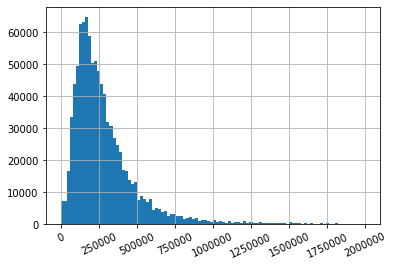

In [11]:
pd.read_sql_query(("""
    select
        price
    from
        house_sales as a
        left join dates as b
            on a.transfer_date = b.date_stamp
    where
        a.price < 2000000 AND
        b.year = 2019
        
"""), conn).price.hist(bins=100, xrot=25)

**4.2.3 Change in average house price since 1995**

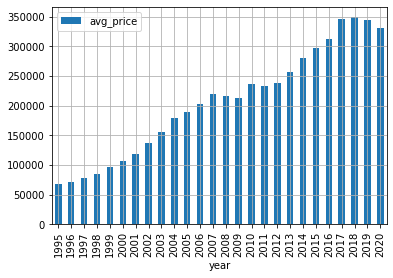

In [12]:
pd.read_sql_query(("""
        select
            d.year
            , count(sale_id) as total_sales
            , avg(a.price) as avg_price
            , max(a.price) as max_price
            , min(a.price) as min_price
        from
            house_sales as a, dates as d
        where
            a.transfer_date = d.date_stamp
        group by 1
        order by 1
"""), conn).plot(x='year', y='avg_price', kind='bar', grid=True)

**4.2.4 Average house price in 2011 by the area classification**

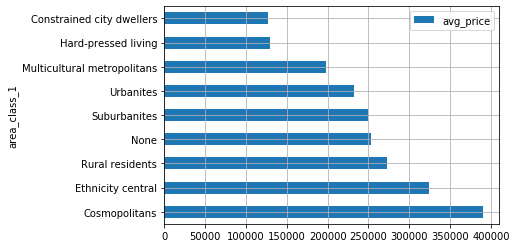

In [13]:
pd.read_sql_query(("""
        select
            distinct(c.area_class_1)
            , avg(a.price) as avg_price
        from
            house_sales as a
            left join dates as b
                on a.transfer_date = b.date_stamp
            left join address_detail_lkp as c
                on a.address_id = c.address_id
        where
            b.year = 2011
        group by 1
        order by 2 desc
"""), conn).plot(x='area_class_1', y='avg_price', kind='barh', grid=True)